In [28]:
import pandas as pd
import numpy as np
from numpy import array, median, sqrt
from hw import Jamshidian as jamsh
from hw import Henrard as henr
from hw import hw_helper
from hw import calibration as hw_calib
from hw.const import *
from fox_toolbox.utils import xml_parser, rates
from random import choice
import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# import seaborn as sns
# sns.set_context("poster")
# sns.set(rc={'figure.figsize': (20, 15)})
# sns.set_style("whitegrid")

from pylab import rcParams
rcParams['figure.figsize'] = 8, 15

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 35}

mpl.rc('font', **font)

np.set_printoptions(precision=10)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read IRSM FORM

In [17]:
irsmform, irsmout = [xml_parser.get_files(regex) for regex in ['irsmform', 'irsmout']]

debug_df = pd.DataFrame()

In [18]:
main_curve, sprds = xml_parser.get_rate_curves(irsmform)
dsc_curve = main_curve

try:
    estim_curve = sprds[0]
except TypeError:
    estim_curve = main_curve

cal_basket = list(xml_parser.get_calib_basket(irsmform))
mr = xml_parser.get_hw_params(irsmform).meanR

### READ IRSM OUT

In [19]:
ref_swos = list(xml_parser.get_calib_basket(irsmout))
ref_mr = mr

In [20]:
ref_sigmas = xml_parser.get_hw_params(irsmout).hw_volatility

## Hernard pricer with its ref sigma

In [21]:
calib_premiumsH = []


for swo in cal_basket:

    henr_price, debug = henr.hw_swo(swo, ref_mr, ref_sigmas, dsc_curve, estim_curve)
    debug_df = pd.concat([debug_df, pd.DataFrame(data=debug)], sort=False)
    calib_premiumsH.append(henr_price)

calib_premiumsH

[0.0017931740720139033,
 0.002306112824953188,
 0.002461182392967276,
 0.0024162054633151686,
 0.0020457933412592055,
 0.001532888951062128,
 0.0008220598086249309]

## HW Calibration

In [22]:
sigma_hw_henr, debug_H = hw_calib.calibrate_sigma_hw(cal_basket, ref_mr, dsc_curve, estim_curve, IsJamsh=False)
sigma_hw_henr

Starting calibration on 7 swaptions with vol type: SLN
 at T=0.2493150684932 vol=0.005297248906822668
 at T=0.5013698630137 vol=0.005919781307533625
 at T=0.7534246575342 vol=0.006370869197544644
 at T=1.0027397260274 vol=0.007252848924601158
 at T=1.2493150684932 vol=0.0064686841434439864
 at T=1.5013698630137 vol=0.007162824033313928
 at T=1.7534246575342 vol=0.007318832546269468


Curve(array([ 0.          ,  0.2493150685,  0.501369863 ,  0.7534246575,
        1.002739726 ,  1.2493150685,  1.501369863 ,  1.7534246575,
       31.7534246575]), array([0.0052972489, 0.0052972489, 0.0059197813, 0.0063708692,
       0.0072528489, 0.0064686841, 0.007162824 , 0.0073188325,
       0.0073188325]), 'PieceWise', 'HW model sigma Henrard')

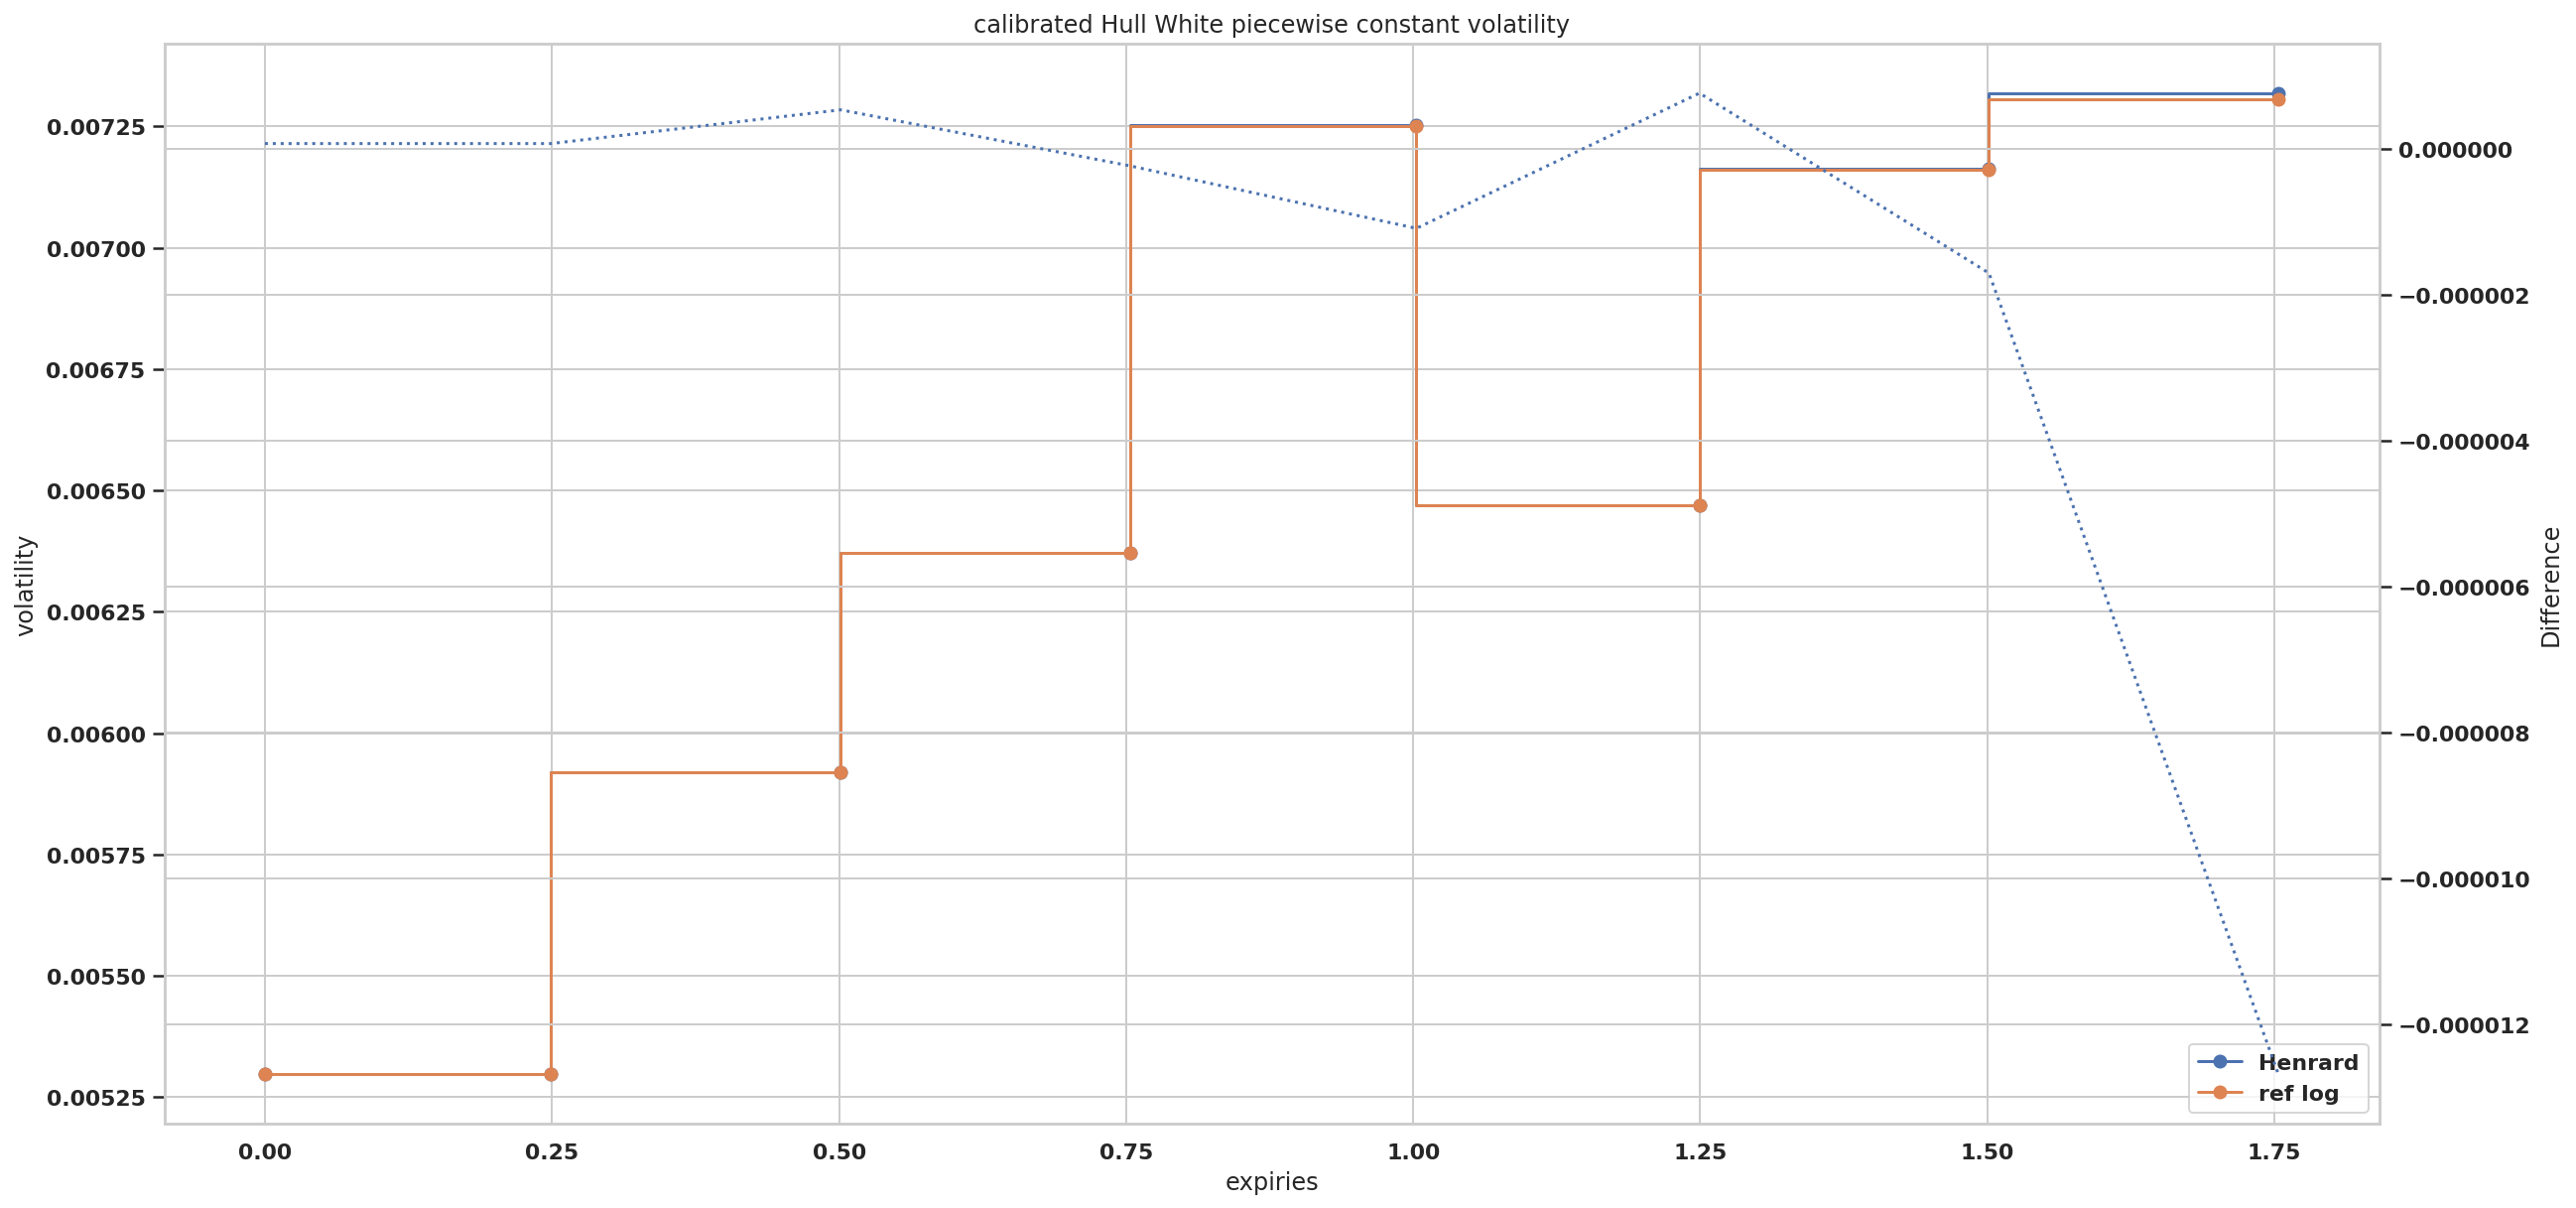

In [23]:
plt.figure(figsize=(20,10))

plt.step(sigma_hw_henr.buckets[:-1],   sigma_hw_henr.values[:-1],   label = 'Henrard', marker='o', where='pre')
plt.step(ref_sigmas.buckets[:-1], ref_sigmas.values[:-1], label = 'ref log', marker='o', where='pre')

plt.legend(loc='lower right')
plt.title('calibrated Hull White piecewise constant volatility')
plt.xlabel('expiries')
plt.ylabel('volatility')

ax = plt.twinx()  # instantiate a second axes that shares the same x-axis
ax.plot(sigma_hw_henr.buckets[:-1], ref_sigmas.values[:-1] - sigma_hw_henr.values[:-1], ls=':')
ax.set_ylabel('Difference');

In [24]:
pricesH = []
for swo in cal_basket:
    henr_price, debug = henr.hw_swo(swo, ref_mr, sigma_hw_henr, dsc_curve, estim_curve)
    pricesH.append(henr_price)

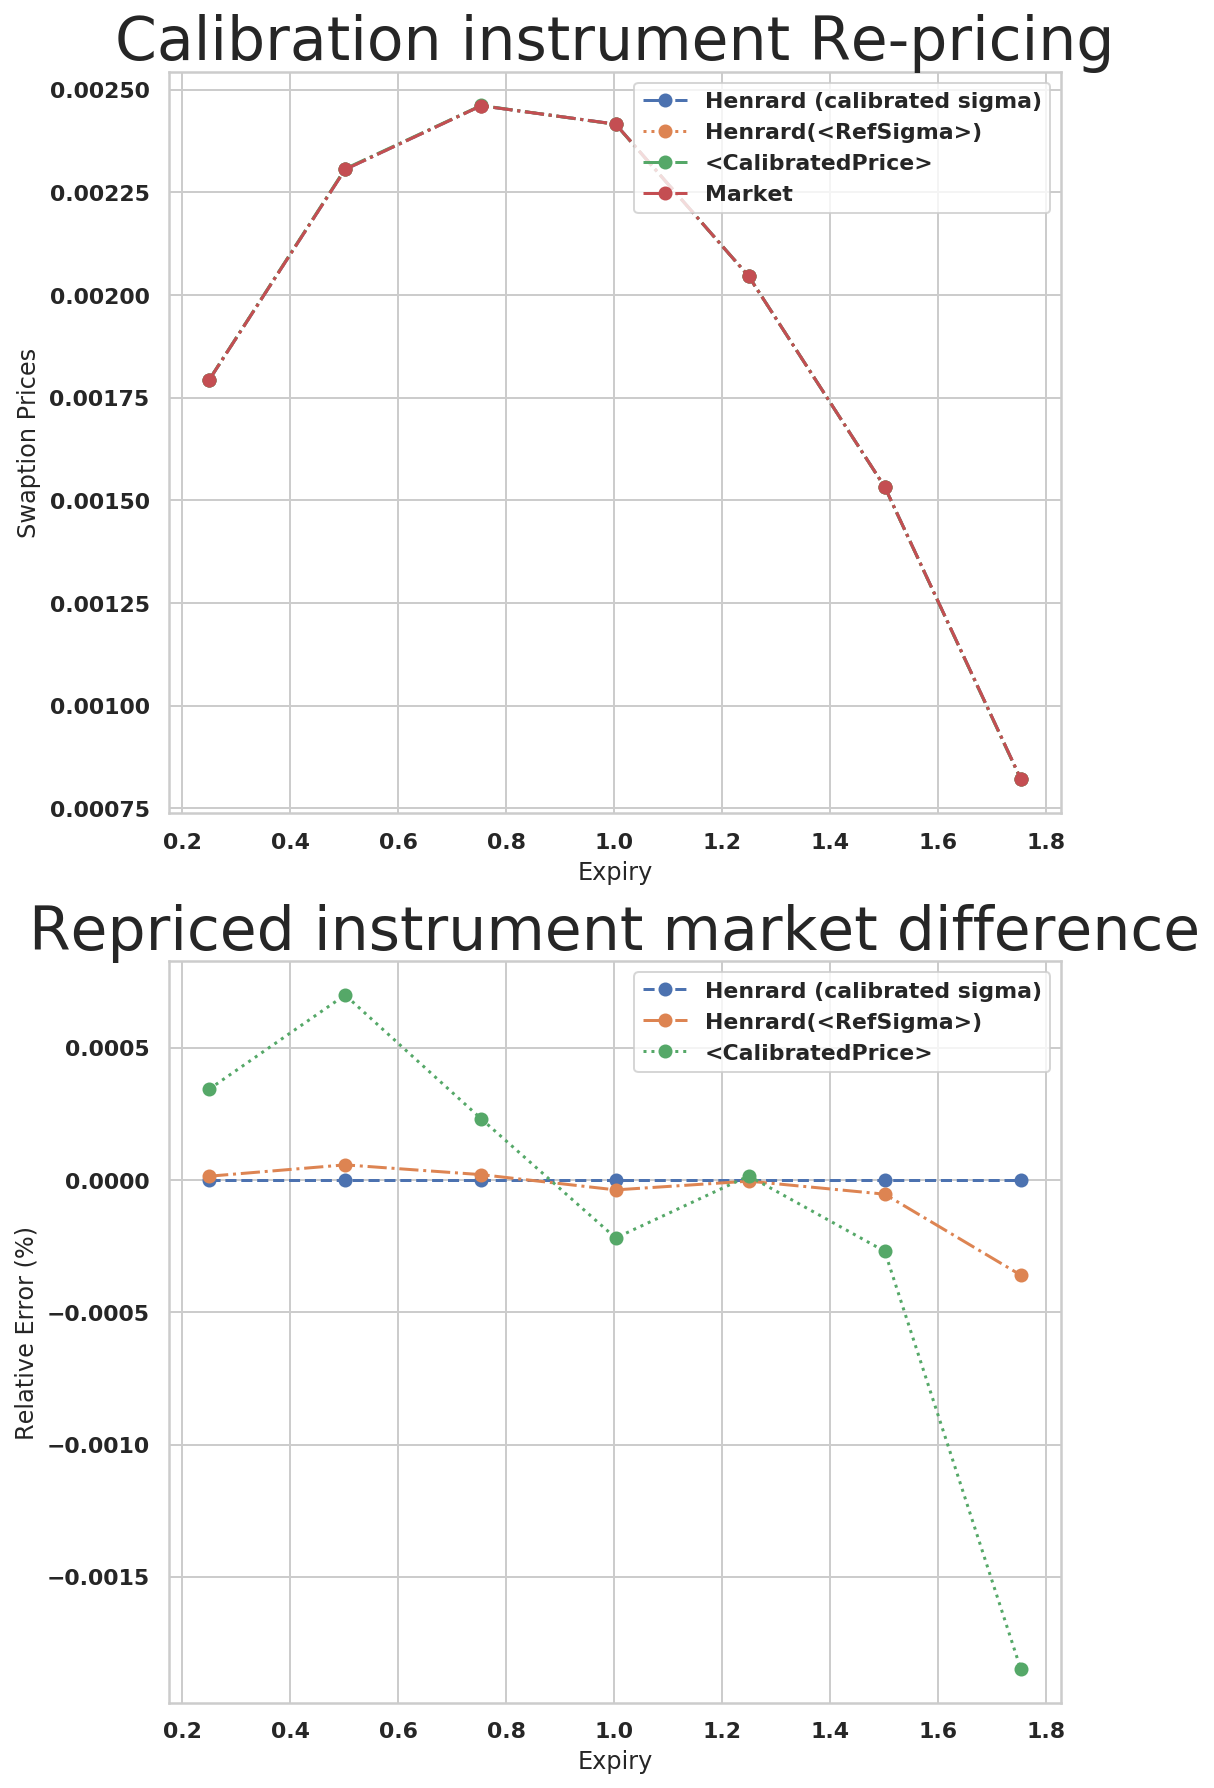

In [33]:
ref_calib_prices = [ref_swo.cal_premium for ref_swo in ref_swos]
black_prices = pd.DataFrame(data=debug_H).target_price

prices_dict = {
               
               'Henrard (calibrated sigma)':array(pricesH),
               'Henrard(<RefSigma>)': array(calib_premiumsH),
               
               '<CalibratedPrice>': array(ref_calib_prices),        
               'Market': array(black_prices)
              }

plt.subplot(2,1,1)
for lbl, prices in prices_dict.items():
    plt.plot([swo.expiry for swo in cal_basket], prices,  label = lbl, linestyle=choice([':', '--', '-.']), marker = 'o');
    
plt.title('Calibration instrument Re-pricing', fontsize= 30);
plt.xlabel('Expiry')
plt.ylabel('Swaption Prices')
plt.legend(loc='upper right');

plt.subplot(2,1,2)
for lbl, prices in list(prices_dict.items())[:-1]:
    plt.plot([swo.expiry for swo in cal_basket], (prices - black_prices)/black_prices,  label = lbl, linestyle=choice([':', '--', '-.']), marker = 'o');

plt.title('Repriced instrument market difference' , fontsize= 30);
plt.xlabel('Expiry')
plt.ylabel('Relative Error (%)')
plt.legend(loc='upper right');

In [26]:
swo1 = cal_basket[-1]
swo1.get_swap_rate(dsc_curve, estim_curve)

0.014283742247892665